# Plot Visitation Distributions

#### Primary Author
Chris Carey

#### Description:
This notebook plots the distribution of food location visitations for various categories among various groupings of census block groups (CBGs).

#### Inputs:
```
data/cbg_attr_and_cluster_1021.csv
exports/home_weekly.csv
exports/poi_health_recategorized.csv
```

#### Visualizations:
> Stacked time-series plots of % of food location visitations by POI category\
> Stacked time-series plots of % of food location visitations by POI category across income percentiles\
> Scatter plots of % of food location visitations by POI category across income percentiles\

In [1]:
import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import pytz

import warnings
warnings.filterwarnings('ignore')

In [2]:
# First week of 2019.
DATE_START = pd.to_datetime('2018-12-31 00:00:00-05:00')
# Last week of 2020.
DATE_END = pd.to_datetime('2020-01-25 00:00:00-05:00')

# First week of 2020.
DATE_START_PLOT = pd.to_datetime('2019-12-30 00:00:00-05:00')
# CUTOFF BEFORE DATA GAP
DATE_END_PLOT = pd.to_datetime('2020-11-23 00:00:00-05:00')

# Start of COVID-19 Pre-Pandemic Period
DATE_START_PRE_COVID = pd.to_datetime('2019-03-18 00:00:00-05:00')
DATE_END_PRE_COVID = pd.to_datetime('2019-11-25 00:00:00-05:00')

# Start of COVID-19 Pandemic Period
DATE_START_COVID = pd.to_datetime('2020-03-16 00:00:00-05:00')
DATE_END_COVID = pd.to_datetime('2020-11-23 00:00:00-05:00')

# First week of 2019 - 1 week.
DATE_START_ROLLING = pd.to_datetime('2018-12-24 00:00:00-05:00')
# Last week of 2020 + 1 week.
DATE_END_ROLLING = pd.to_datetime('2021-02-01 00:00:00-05:00')

In [3]:
# https://cran.r-project.org/web/packages/khroma/vignettes/tol.html + NYU
COLORS = [
    '#57068c', '#e0b6fc', '#825', '#173', '#dc7', '#4a9', '#c67', '#993', '#a49']
LINE_STYLES = [
    'solid',
    'dashed',
    (0, (1, 1)),
    'dashdot',
    'solid',
    (0, (5, 1)),
    (0, (3, 1, 1, 1, 1, 1)),
    'dashed',
    'dashdot',
]

In [4]:
def peek(df):
    display(df.iloc[0:3, :])
    print(len(df))

In [5]:
def repair_dates(df):
    df['date_range_start'] = pd.to_datetime(df['date_range_start'], utc=True)
    df['date_range_start'] = df['date_range_start'].dt.tz_convert('US/Eastern')

In [6]:
def repair_dt_index(df):
    dt_start = df.index[0][0]
    dt_end = df.index[-1][0]
    dt_index = pd.date_range(dt_start, dt_end, freq='W-MON')
    cluster_index = list(set(df.reset_index(level=1)['cluster']))
    cluster_index.sort()
    multi_index = pd.MultiIndex.from_product(
        [dt_index, cluster_index], names=['date_range_start', 'cluster'])
    df = df.reindex(multi_index)
    return df

In [7]:
def smoothen(df, columns=[], N=2):
    """Returns a copy of the given dataframe with a rolling-day average of the
    given size applied to the given columns."""
    rolling_groupby = df.copy().reset_index(level=1).groupby(by=['cluster'])
    rolling_df = rolling_groupby[columns].rolling(N + 1, center=True).mean()
    rolling_df = rolling_df.reset_index()
    rolling_df = rolling_df.sort_values(by=['date_range_start', 'cluster'])
    rolling_df = rolling_df.set_index(['date_range_start', 'cluster'])
    return rolling_df

def smoothen_within(df, columns=[], by=None, N=6):
    """Returns a copy of the given dataframe with a rolling-day average of the
    given size applied to the given columns within each attribute class
    determined by the given "by" attribute."""
    attr_classes = set(df[by])
    rolling_dfs = []
    for attr_class in attr_classes:
        attr_class_df = df[df[by] == attr_class]
        rolling_dfs.append(smoothen(attr_class_df, columns, N=N))
    rolling_df = pd.concat(rolling_dfs)
    rolling_df = rolling_df.sort_values(by=['date_range_start', by])
    return rolling_df

## Plot % of Food Location Visitations by POI Category

In [8]:
home_weekly_df = pd.read_csv(f'./exports/home_weekly.csv')
repair_dates(home_weekly_df)
home_weekly_df = home_weekly_df[(home_weekly_df['date_range_start'] >=
                                 DATE_START_ROLLING)]
home_weekly_df = home_weekly_df[(home_weekly_df['date_range_start'] <=
                                 DATE_END_ROLLING)]
home_weekly_df = home_weekly_df.rename(columns={'home_cbg': 'cbg'})
peek(home_weekly_df)

,placekey,date_range_start,cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi
0,236-222@627-s7z-b6k,2018-12-31 00:00:00-05:00,360050001001,4,264.000000,0.250000,0.250000,20.076046
1,236-222@627-s7z-b6k,2018-12-31 00:00:00-05:00,360050210021,4,6.697436,0.013158,0.013158,0.509311
2,236-222@627-s7z-b6k,2018-12-31 00:00:00-05:00,360470285021,4,7.414691,0.007273,0.007273,0.563855


27486619


In [9]:
poi_df = pd.read_csv(f'./exports/poi_health_recategorized.csv')
categories = list(set(poi_df['category']))
peek(poi_df)

,placekey,cbg,naics_code,category,sub_category,location_name,area_square_feet,latitude,longitude
0,222-222@627-s94-nwk,360470395002,445210,Specialty Food Stores,Meat Markets,Broadway Meats,3177.0,40.691436,-73.924891
1,223-222@627-rw6-zfz,360050386008,445110,Supermarkets and Grocery Stores,Supermarkets and Other Grocery (except Conveni...,Foodtown,3401.0,40.876890,-73.847776
2,223-222@627-rwq-vcq,360050117001,445110,Supermarkets and Grocery Stores,Supermarkets and Other Grocery (except Conveni...,Kirsch Mushroom Company,10079.0,40.816779,-73.883401


36475


In [10]:
def apply_cluster_by_income(df):
    cdf = df.copy()
    median_income = 63998
    
    pct10 = np.percentile(cdf['income'].dropna(), 10)
    pct50 = np.percentile(cdf['income'].dropna(), 50)
    pct90 = np.percentile(cdf['income'].dropna(), 90)
    print(pct10, pct50, pct90)
    
    cdf['cluster'] = None
    cdf.loc[(cdf['income'] <= pct10), 'cluster'] = 0
    cdf.loc[(cdf['income'] > pct10) & (cdf['income'] <= pct50), 'cluster'] = 1
    cdf.loc[(cdf['income'] > pct50) & (cdf['income'] <= pct90), 'cluster'] = 2
    cdf.loc[(cdf['income'] > pct90), 'cluster'] = 3
    return cdf

In [11]:
cbg_df = pd.read_csv('./data/cbg_attr_and_cluster_1021.csv')
cbg_df = cbg_df.rename(
    columns={
        'census_block_group':
            'cbg',
        'Median Household Income':
            'income',
        'Total Population':
            'population',
        'Percent Households with one or more people under 18 years':
            'pct_children',
        'Percent Household received Food Stamps/SNAP':
            'pct_snap',
        'Percent Households Income in the past 12 months below poverty level':
            'pct_poverty',
        'Cluster':
            'kmeans_cluster',
    })

In [12]:
cbg_df = apply_cluster_by_income(cbg_df)
cbg_cluster_df = cbg_df[['cbg', 'cluster']]
home_cluster_df = home_weekly_df.merge(cbg_df[['cbg', 'cluster']], on=['cbg'], how='inner')

30140.0 68164.0 128646.0


In [13]:
def get_total_df(cluster_df):
    total_df = cluster_df.groupby(by=['date_range_start', 'cluster']).agg(
        {
            'estimated_visitor_count': 'sum'
        }).reset_index()
    total_df = total_df.rename(
        columns={'estimated_visitor_count': 'total_estimated_visitor_count'})
    total_df = total_df.sort_values(by=['date_range_start', 'cluster'])
    peek(total_df)
    return total_df

In [14]:
def get_weekly_df(cluster_df, total_df, poi_df=poi_df):
    weekly_df = cluster_df.merge(poi_df[['placekey', 'category']],
                                    on='placekey',
                                    how='inner')
    weekly_df = weekly_df.groupby(by=['date_range_start', 'category', 'cluster']).agg({
        'estimated_visitor_count': 'sum'
    }).reset_index()
    weekly_df = weekly_df.merge(total_df,
                            on=['date_range_start', 'cluster'],
                            how='inner')
    weekly_df = weekly_df.sort_values(by=['date_range_start', 'category', 'cluster'])
    weekly_df['percent'] = weekly_df['estimated_visitor_count'] / weekly_df[
        'total_estimated_visitor_count']
    peek(weekly_df)
    return weekly_df

In [15]:
def get_percent_df(weekly_df):
    percent_df = weekly_df.pivot(index=['date_range_start', 'cluster'],
                                 columns=['category'],
                                 values=['percent'])
    percent_df = repair_dt_index(percent_df)
    percent_df = smoothen(percent_df, percent_df.columns)
    percent_df.columns = percent_df.columns.get_level_values(1)
    peek(percent_df)
    return percent_df

In [16]:
total_df = get_total_df(home_cluster_df)
weekly_df = get_weekly_df(home_cluster_df, total_df)
percent_df = get_percent_df(weekly_df)

,date_range_start,cluster,total_estimated_visitor_count
0,2018-12-31 00:00:00-05:00,0,2.617732e+05
1,2018-12-31 00:00:00-05:00,1,1.145516e+06
2,2018-12-31 00:00:00-05:00,2,1.082686e+06


432


,date_range_start,category,cluster,estimated_visitor_count,total_estimated_visitor_count,percent
0,2018-12-31 00:00:00-05:00,"Beer, Wine, and Liquor Stores",0,3704.755953,2.617732e+05,0.014153
14,2018-12-31 00:00:00-05:00,"Beer, Wine, and Liquor Stores",1,14846.567809,1.145516e+06,0.012961
28,2018-12-31 00:00:00-05:00,"Beer, Wine, and Liquor Stores",2,11867.480254,1.082686e+06,0.010961


6048


category                           Beer, Wine, and Liquor Stores  \
date_range_start          cluster                                  
2018-12-31 00:00:00-05:00 0                                  NaN   
                          1                                  NaN   
                          2                                  NaN   

category                           Big Box Grocers  \
date_range_start          cluster                    
2018-12-31 00:00:00-05:00 0                    NaN   
                          1                    NaN   
                          2                    NaN   

category                           Delis and Convenience Stores  \
date_range_start          cluster                                 
2018-12-31 00:00:00-05:00 0                                 NaN   
                          1                                 NaN   
                          2                                 NaN   

category                           Drinking Places  Fast Food Restaurants  \
date_range_start          cluster                                           
2018-12-31 00:00:00-05:00 0                    NaN                    NaN   
                          1                    NaN                    NaN   
                          2                    NaN                    NaN   

category                           Food Services  Full-Service Restaurants  \
date_range_start          cluster                                            
2018-12-31 00:00:00-05:00 0                  NaN                       NaN   
                          1                  NaN                       NaN   
                          2                  NaN                       NaN   

category                           General Merchandise Stores  \
date_range_start          cluster                               
2018-12-31 00:00:00-05:00 0                               NaN   
                          1                               NaN   
                          2                               NaN   

category                           Limited-Service Restaurants  \
date_range_start          cluster                                
2018-12-31 00:00:00-05:00 0                                NaN   
                          1                                NaN   
                          2                                NaN   

category                           Pharmacies and Drug Stores  \
date_range_start          cluster                               
2018-12-31 00:00:00-05:00 0                               NaN   
                          1                               NaN   
                          2                               NaN   

category                           Snacks and Bakeries  Specialty Food Stores  \
date_range_start          cluster                                               
2018-12-31 00:00:00-05:00 0                        NaN                    NaN   
                          1                        NaN                    NaN   
                          2                        NaN                    NaN   

category                           Supermarkets and Grocery Stores  \
date_range_start          cluster                                    
2018-12-31 00:00:00-05:00 0                                    NaN   
                          1                                    NaN   
                          2                                    NaN   

category                           Tobacco Stores  
date_range_start          cluster                  
2018-12-31 00:00:00-05:00 0                   NaN  
                          1                   NaN  
                          2                   NaN

440


In [17]:
# Verify that percentages sum to 100%.
check_df = weekly_df.groupby(by=['date_range_start', 'cluster']).agg({
    'estimated_visitor_count': 'sum',
    'total_estimated_visitor_count': 'first',
    'percent': 'sum',
})
TOLERANCE = 0.001
print('Weeks not summing to 100%:')
display(len(check_df[check_df['percent'] < 1 - TOLERANCE]))
display(len(check_df[check_df['percent'] > 1 + TOLERANCE]))
peek(check_df)

Weeks not summing to 100%:


0

0

estimated_visitor_count  \
date_range_start          cluster                            
2018-12-31 00:00:00-05:00 0                   2.617900e+05   
                          1                   1.146184e+06   
                          2                   1.083031e+06   

                                   total_estimated_visitor_count   percent  
date_range_start          cluster                                           
2018-12-31 00:00:00-05:00 0                         2.617732e+05  1.000064  
                          1                         1.145516e+06  1.000583  
                          2                         1.082686e+06  1.000318

432


In [18]:
FONT_SIZE_TICKS=13
FONT_SIZE_AXIS=14
FONT_SIZE_TITLE=16
FONT_SIZE_LEGEND=14

In [19]:
def plot_stack_all(df,
                   columns=[],
                   labels=[],
                   legendy=-0.25,
                   title='',
                   yaxis_zero=False,
                   ylim=None):
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))

    df = df[df.index >= DATE_START_PLOT]
    df = df[df.index <= DATE_END_PLOT]

    stacks = ax[0].stackplot(df.index, df.transpose(), colors=COLORS, alpha=0.8)
    ax[0].axvline(datetime.datetime(2020, 3, 20), linestyle='--', color='#000')

    for j, label in enumerate(columns):
        ax[1].plot(df.index,
                   df.iloc[:, j],
                   color=COLORS[j % len(COLORS)],
                   label=label,
                   linewidth=3,
                   linestyle=LINE_STYLES[j % len(LINE_STYLES)])

    ax[1].axvline(datetime.datetime(2020, 3, 20), linestyle='--', color='#000')

    legend = plt.legend(bbox_to_anchor=(0.45, legendy, 0.1, 0.1),
                        ncol=min(len(columns), 3),
                        loc='lower center',
                        bbox_transform=fig.transFigure,
                        fontsize=14,
                        handlelength=3.5)

    for handle in legend.legendHandles:
        handle.set_linewidth(3.5)

    ax[0].yaxis.set_tick_params(labelleft=True)
    ax[1].yaxis.set_tick_params(labelleft=True)
    ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    ax[0].set_ylabel('% of Visitations', fontsize=FONT_SIZE_AXIS)

    tzinfo = pytz.timezone('US/Eastern')

    ax[0].set_ylim([0, 1])
    if yaxis_zero:
        ax[1].set_ylim(bottom=0)
    if ylim:
        ax[1].set_ylim(ylim)
        
    ax[0].grid(color='#353535', alpha=0.9)
    ax[1].grid(color='#bdbdbd', alpha=0.6)

    for sax in ax:
        sax.set_xlim([DATE_START_PLOT, DATE_END_PLOT])
        sax.tick_params(axis='y', which='major', pad=5)
        sax.xaxis.set_ticks([
            datetime.datetime(2020, 1, 2, 0, 0, tzinfo=tzinfo),
            datetime.datetime(2020, 4, 1, 0, 0, tzinfo=tzinfo),
            datetime.datetime(2020, 7, 1, 0, 0, tzinfo=tzinfo),
            datetime.datetime(2020, 10, 1, 0, 0, tzinfo=tzinfo),
        ])
        sax.tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
        sax.xaxis.set_ticklabels([
            'Jan.\n2020',
            'Apr.\n2020',
            'Aug.\n2020',
            'Oct.\n2020',
        ],
                                 fontsize=FONT_SIZE_TICKS)
        plt.setp(sax.spines.values(), color='#000000')

    #plt.tight_layout()
    #plt.legend(fontsize=14)
    plt.show()

### Combined Categories

In [20]:
cbg_all_df = cbg_df.copy()
cbg_all_df['cluster'] = 0
cbg_all_df = cbg_all_df[['cbg', 'cluster']]

poi_other_df = poi_df.copy()

other_retail = [
    'Beer, Wine, and Liquor Stores',
    'Big Box Grocers',
    'Delis and Convenience Stores',
    'Food Services',
    'General Merchandise Stores',
    'Specialty Food Stores',
    'Tobacco Stores',
]

other_service = [
    'Drinking Places',
    'Snacks and Bakeries',
]

poi_other_df.loc[poi_other_df['category'].isin(other_retail),
                 'category'] = 'Other Food Retail'
poi_other_df.loc[poi_other_df['category'].isin(other_service),
                 'category'] = 'Other Food Service'
all_cluster_df = home_weekly_df.merge(cbg_all_df, on=['cbg'], how='inner')
all_total_df = get_total_df(all_cluster_df)
all_weekly_df = get_weekly_df(all_cluster_df, all_total_df, poi_df=poi_other_df)
all_percent_df = get_percent_df(all_weekly_df).reset_index(level=1).drop(
    columns=['cluster'])

,date_range_start,cluster,total_estimated_visitor_count
0,2018-12-31 00:00:00-05:00,0,2.928497e+06
1,2019-01-07 00:00:00-05:00,0,3.003710e+06
2,2019-01-14 00:00:00-05:00,0,3.031448e+06


108


,date_range_start,category,cluster,estimated_visitor_count,total_estimated_visitor_count,percent
0,2018-12-31 00:00:00-05:00,Fast Food Restaurants,0,3.504073e+05,2.928497e+06,0.119654
1,2018-12-31 00:00:00-05:00,Full-Service Restaurants,0,1.098833e+06,2.928497e+06,0.375221
2,2018-12-31 00:00:00-05:00,Limited-Service Restaurants,0,2.859201e+05,2.928497e+06,0.097634


756


,category,Fast Food Restaurants,Full-Service Restaurants,Limited-Service Restaurants,Other Food Retail,Other Food Service,Pharmacies and Drug Stores,Supermarkets and Grocery Stores
date_range_start,cluster,,,,,,,
2018-12-31 00:00:00-05:00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-07 00:00:00-05:00,0,0.120338,0.371491,0.099251,0.126762,0.161887,0.059639,0.060975
2019-01-14 00:00:00-05:00,0,0.120460,0.371065,0.100455,0.125619,0.162821,0.059228,0.060689


110


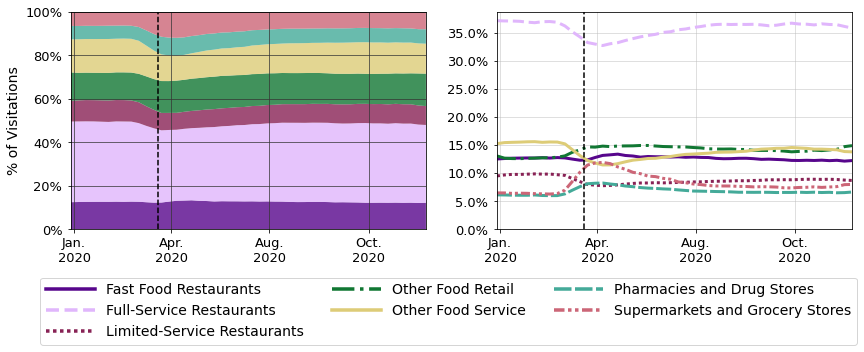

In [21]:
plot_stack_all(all_percent_df, columns=all_percent_df.columns, yaxis_zero=True, legendy=-.3)

### Food Retail vs. Service

In [22]:
# RS = Retail/Service
poi_rs_df = poi_df.copy()

retail = [
    'Beer, Wine, and Liquor Stores',
    'Big Box Grocers',
    'Delis and Convenience Stores',
    'Food Services',
    'General Merchandise Stores',
    'Pharmacies and Drug Stores',
    'Specialty Food Stores',
    'Supermarkets and Grocery Stores',
    'Tobacco Stores',
]

service = [
    'Drinking Places',
    'Fast Food Restaurants',
    'Full-Service Restaurants',
    'Limited-Service Restaurants',
    'Snacks and Bakeries',
]

poi_rs_df.loc[poi_rs_df['category'].isin(retail), 'category'] = 'Food Retail'
poi_rs_df.loc[poi_rs_df['category'].isin(service), 'category'] = 'Food Service'

In [23]:
cbg_all_df = cbg_df.copy()
cbg_all_df['cluster'] = 0
cbg_all_df = cbg_all_df[['cbg', 'cluster']]
all_cluster_df = home_weekly_df.merge(cbg_all_df, on=['cbg'], how='inner')
all_total_df = get_total_df(all_cluster_df)
all_weekly_df = get_weekly_df(all_cluster_df, all_total_df, poi_df=poi_rs_df)
all_percent_df = get_percent_df(all_weekly_df).reset_index(level=1)
all_percent_df = all_percent_df.drop(columns=['cluster'])

,date_range_start,cluster,total_estimated_visitor_count
0,2018-12-31 00:00:00-05:00,0,2.928497e+06
1,2019-01-07 00:00:00-05:00,0,3.003710e+06
2,2019-01-14 00:00:00-05:00,0,3.031448e+06


108


,date_range_start,category,cluster,estimated_visitor_count,total_estimated_visitor_count,percent
0,2018-12-31 00:00:00-05:00,Food Retail,0,7.220525e+05,2.928497e+06,0.246561
1,2018-12-31 00:00:00-05:00,Food Service,0,2.207536e+06,2.928497e+06,0.753812
2,2019-01-07 00:00:00-05:00,Food Retail,0,7.385506e+05,3.003710e+06,0.245879


216


,category,Food Retail,Food Service
date_range_start,cluster,,
2018-12-31 00:00:00-05:00,0,NaN,NaN
2019-01-07 00:00:00-05:00,0,0.247376,0.752967
2019-01-14 00:00:00-05:00,0,0.245537,0.754801


110


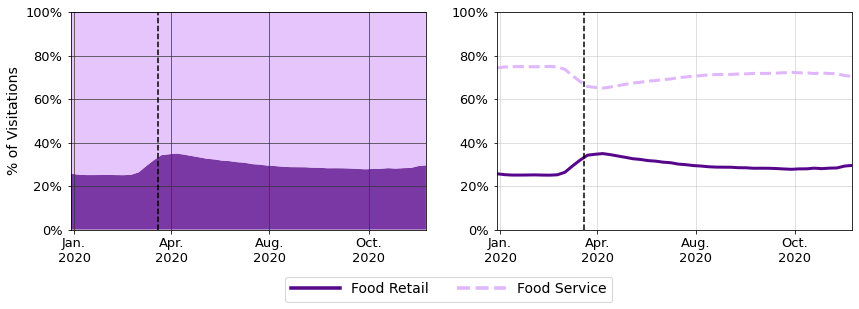

In [24]:
plot_stack_all(all_percent_df, columns=all_percent_df.columns, legendy=-0.15, ylim=[0,1])

## By Income Percentile

In [25]:
def plot_stack(df, n_clusters=1, columns=[], labels=[], title=''):
    fig, ax = plt.subplots(2, n_clusters, figsize=(24, 8))
    
    for i in range(1, n_clusters):
        ax[0, i].sharey(ax[0, 0])
        ax[1, i].sharey(ax[1, 0])

    cmap = plt.cm.get_cmap('tab20')
    colors = [cmap(i / 20) for i in range(0, 20)]

    rdf = df.reset_index(level=1)
    for i in range(n_clusters):
        cdf = rdf[rdf['cluster'] == i].drop(columns=['cluster'])[columns]
        ax[0, i].stackplot(cdf.index, cdf.transpose(), labels=[c for c in columns], colors=colors, alpha=0.8)
        ax[0, i].axvline(datetime.datetime(2020, 3, 20), linestyle='--', color='#000')

        for j, label in enumerate(columns):
            ax[1, i].plot(cdf.index, cdf.iloc[:, j], color=colors[j], label=label)
        ax[1, i].axvline(datetime.datetime(2020, 3, 20), linestyle='--', color='#000')
        
        if i == 0:
            ax[0, i].legend(loc='lower left')
            ax[1, i].legend(loc='lower left')
            
    
        ax[0, i].yaxis.set_tick_params(labelleft=True)
        ax[1, i].yaxis.set_tick_params(labelleft=True)
        ax[0, i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax[1, i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        
    for i, label in enumerate(labels):
        ax[0, i].set_title(label)
            
    plt.suptitle(title, fontsize=18)
    plt.tight_layout()
    plt.show()

## Scatter plots 2019 vs. 2020

In [26]:
def apply_percentiles_by_income(df):
    cdf = df.copy()
    percents = list(range(5, 105, 5))
    values = [np.percentile(cdf['income'].dropna(), p) for p in percents]
    
    cdf['cluster'] = None
    for i, value in enumerate(values):
        cdf.loc[(cdf['cluster'].isna()) & (cdf['income'] <= value), 'cluster'] = percents[i] 
    return cdf

In [27]:
cbg_pct_df = apply_percentiles_by_income(cbg_df)
cbg_pct_df = cbg_pct_df[['cbg', 'cluster']]
pct_cluster_df = home_weekly_df.merge(cbg_pct_df, on=['cbg'], how='inner')
pct_total_df = get_total_df(pct_cluster_df)
pct_weekly_df = get_weekly_df(pct_cluster_df, pct_total_df)
pct_percent_df = get_percent_df(pct_weekly_df)

,date_range_start,cluster,total_estimated_visitor_count
0,2018-12-31 00:00:00-05:00,5,130362.730020
1,2018-12-31 00:00:00-05:00,10,131410.450158
2,2018-12-31 00:00:00-05:00,15,132556.225098


2160


,date_range_start,category,cluster,estimated_visitor_count,total_estimated_visitor_count,percent
0,2018-12-31 00:00:00-05:00,"Beer, Wine, and Liquor Stores",5,1919.379619,130362.730020,0.014723
14,2018-12-31 00:00:00-05:00,"Beer, Wine, and Liquor Stores",10,1785.376335,131410.450158,0.013586
28,2018-12-31 00:00:00-05:00,"Beer, Wine, and Liquor Stores",15,1812.516789,132556.225098,0.013674


30240


category                           Beer, Wine, and Liquor Stores  \
date_range_start          cluster                                  
2018-12-31 00:00:00-05:00 5                                  NaN   
                          10                                 NaN   
                          15                                 NaN   

category                           Big Box Grocers  \
date_range_start          cluster                    
2018-12-31 00:00:00-05:00 5                    NaN   
                          10                   NaN   
                          15                   NaN   

category                           Delis and Convenience Stores  \
date_range_start          cluster                                 
2018-12-31 00:00:00-05:00 5                                 NaN   
                          10                                NaN   
                          15                                NaN   

category                           Drinking Places  Fast Food Restaurants  \
date_range_start          cluster                                           
2018-12-31 00:00:00-05:00 5                    NaN                    NaN   
                          10                   NaN                    NaN   
                          15                   NaN                    NaN   

category                           Food Services  Full-Service Restaurants  \
date_range_start          cluster                                            
2018-12-31 00:00:00-05:00 5                  NaN                       NaN   
                          10                 NaN                       NaN   
                          15                 NaN                       NaN   

category                           General Merchandise Stores  \
date_range_start          cluster                               
2018-12-31 00:00:00-05:00 5                               NaN   
                          10                              NaN   
                          15                              NaN   

category                           Limited-Service Restaurants  \
date_range_start          cluster                                
2018-12-31 00:00:00-05:00 5                                NaN   
                          10                               NaN   
                          15                               NaN   

category                           Pharmacies and Drug Stores  \
date_range_start          cluster                               
2018-12-31 00:00:00-05:00 5                               NaN   
                          10                              NaN   
                          15                              NaN   

category                           Snacks and Bakeries  Specialty Food Stores  \
date_range_start          cluster                                               
2018-12-31 00:00:00-05:00 5                        NaN                    NaN   
                          10                       NaN                    NaN   
                          15                       NaN                    NaN   

category                           Supermarkets and Grocery Stores  \
date_range_start          cluster                                    
2018-12-31 00:00:00-05:00 5                                    NaN   
                          10                                   NaN   
                          15                                   NaN   

category                           Tobacco Stores  
date_range_start          cluster                  
2018-12-31 00:00:00-05:00 5                   NaN  
                          10                  NaN  
                          15                  NaN

2200


In [28]:
pct_percent_2019_df = pct_percent_df.reset_index()
pct_percent_2019_df = pct_percent_2019_df[
    pct_percent_2019_df['date_range_start'] >= DATE_START_PRE_COVID]
pct_percent_2019_df = pct_percent_2019_df[
    pct_percent_2019_df['date_range_start'] <= DATE_END_PRE_COVID]
pct_percent_2019_df = pct_percent_2019_df.set_index(['date_range_start'])
pct_percent_2019_mean_df = pct_percent_2019_df.groupby(by=['cluster']).mean()
pct_percent_2020_df = pct_percent_df.reset_index()
pct_percent_2020_df = pct_percent_2020_df[
    pct_percent_2020_df['date_range_start'] >= DATE_START_COVID]
pct_percent_2020_df = pct_percent_2020_df[
    pct_percent_2020_df['date_range_start'] >= DATE_END_COVID]
pct_percent_2020_df = pct_percent_2020_df.set_index(['date_range_start'])
pct_percent_2020_mean_df = pct_percent_2020_df.groupby(by=['cluster']).mean()

In [29]:
def plot_scatter(df1, df2, columns, yaxis_zero=True, last_col=-1):
    fig, ax = plt.subplots(3, len(columns), figsize=(5 * len(columns), 4 * 3))
    # Ignore top 1 percentiles due to 250+ reporting / outliers.
    for i, column in enumerate(columns):
        ax[0, i].scatter(df1.index[0:last_col],
                         df1.iloc[0:last_col][column],
                         color=COLORS[1],
                         label='Mar.-Nov. 2019',
                         zorder=2)
        ax[0, i].scatter(df2.index[0:last_col],
                         df2.iloc[0:last_col][column],
                         color=COLORS[0],
                         label='Mar.-Nov. 2020',
                         zorder=3)
        ax[0, i].set_title(column, fontsize=FONT_SIZE_TITLE)
        ax[0, i].xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
        ax[0,
           i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
        ax[0, i].set_xlabel('Home CBG Income Percentile',
                            fontsize=FONT_SIZE_AXIS)
        ax[0, i].tick_params(axis='x', labelsize=FONT_SIZE_TICKS)
        ax[0, i].tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
        ax[0, i].sharey(ax[0, 0])
        ax[0, i].grid(color='#bdbdbd', alpha=0.6, zorder=1)
        ax[0, i].set_axisbelow(True)
    ax[0, 0].legend(fontsize=FONT_SIZE_LEGEND)

    for i, column in enumerate(columns):
        ax[1, i].scatter(
            df1.index[0:last_col],
            (df2.iloc[0:last_col][column] - df1.iloc[0:last_col][column]),
            color=COLORS[2],
            zorder=2)
        ax[1, i].set_title('Change (pp) from 2019 to 2020 (Mar.-Nov.)',
                           fontsize=FONT_SIZE_TITLE - 2)
        ax[1, i].xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
        ax[1,
           i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
        ax[1, i].set_xlabel('Home CBG Income Percentile',
                            fontsize=FONT_SIZE_AXIS)
        ax[1, i].tick_params(axis='x', labelsize=FONT_SIZE_TICKS)
        ax[1, i].tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
        ax[1, i].grid(color='#bdbdbd', alpha=0.6, zorder=1)
        ax[1, i].set_axisbelow(True)
        # Draw horizontal line at zero
        if ax[1, i].get_ylim()[0] < 0 and ax[1, i].get_ylim()[1] > 0:
            ax[1, i].axhline(0, linestyle='-', color='#bbb', zorder=1)

    for i, column in enumerate(columns):
        ax[2, i].scatter(
            df1.index[0:last_col],
            (df2.iloc[0:last_col][column] - df1.iloc[0:last_col][column]) /
            df1.iloc[0:last_col][column],
            color=COLORS[5],
            zorder=2)
        ax[2, i].set_title('Change (%) from 2019 to 2020 (Mar.-Nov.)',
                           fontsize=FONT_SIZE_TITLE - 2)
        ax[2, i].xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
        ax[2,
           i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
        ax[2, i].set_xlabel('Home CBG Income Percentile',
                            fontsize=FONT_SIZE_AXIS)
        ax[2, i].tick_params(axis='x', labelsize=FONT_SIZE_TICKS)
        ax[2, i].tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
        ax[2, i].grid(color='#bdbdbd', alpha=0.6, zorder=1)
        ax[2, i].set_axisbelow(True)
        # Draw horizontal line at zero
        if ax[2, i].get_ylim()[0] < 0 and ax[1, i].get_ylim()[1] > 0:
            ax[2, i].axhline(0, linestyle='-', color='#bbb', zorder=1)

    ax[0, 0].set_ylabel('% of Visitations', fontsize=FONT_SIZE_AXIS)
    ax[1, 0].set_ylabel('Change of % of Visitations', fontsize=FONT_SIZE_AXIS)
    ax[2, 0].set_ylabel('% Change of % of Visitations', fontsize=FONT_SIZE_AXIS)

    #plt.suptitle('5% percentiles (Income)', fontsize=18)
    plt.tight_layout()
    plt.plot()

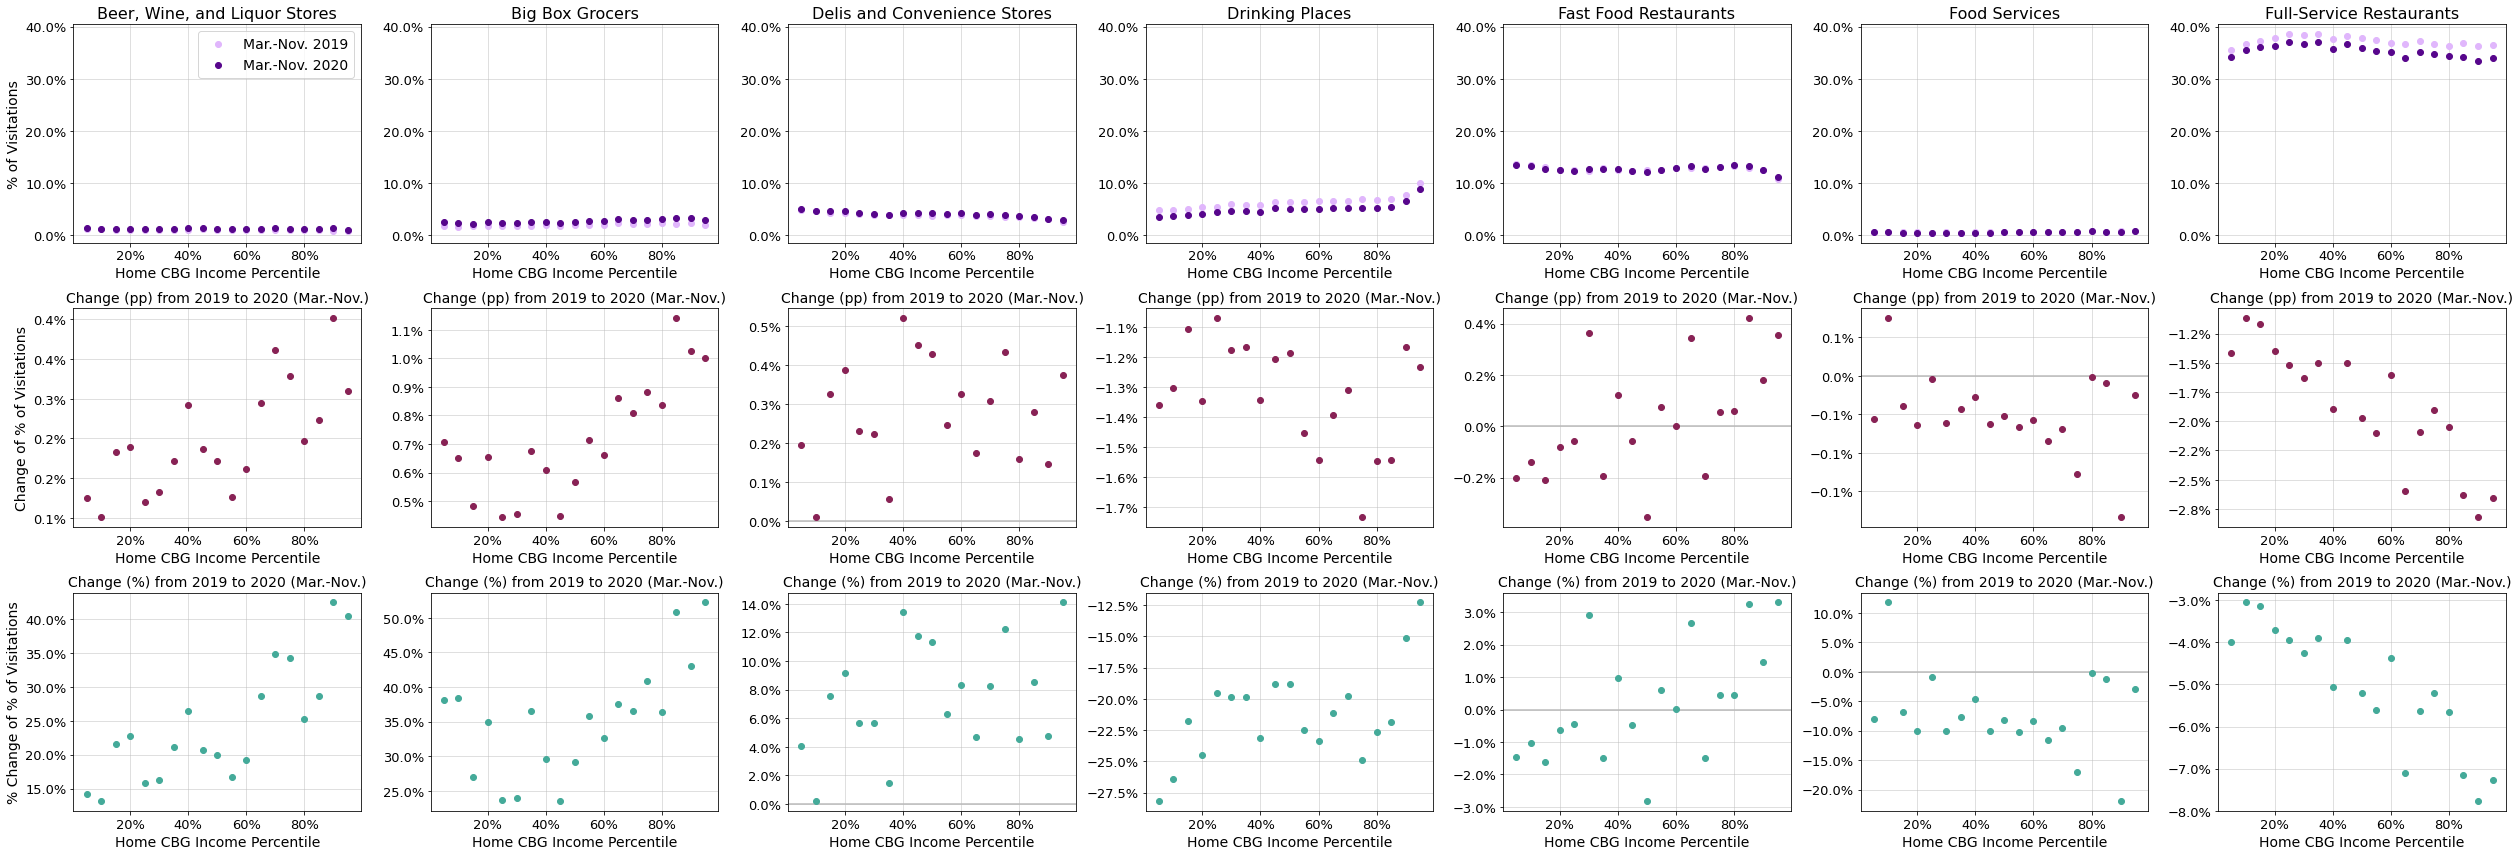

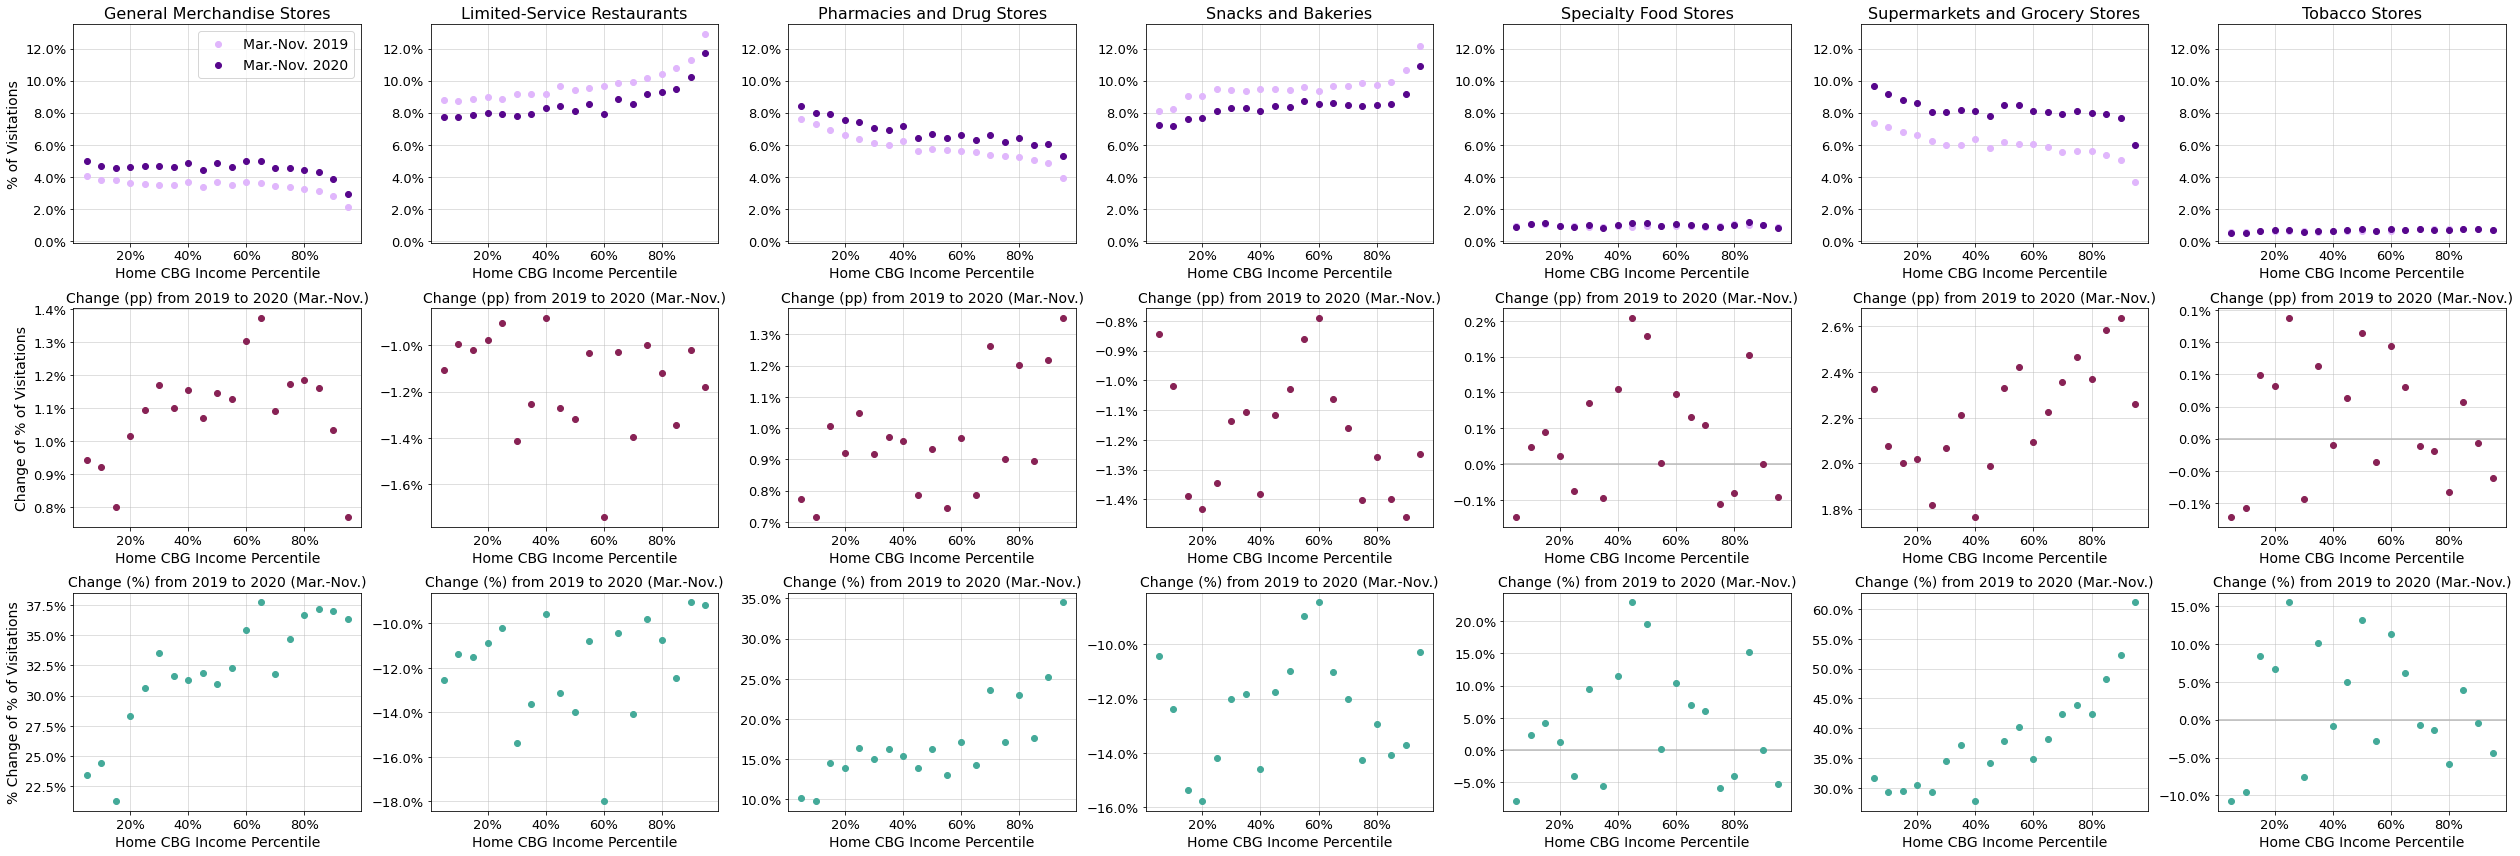

In [30]:
pdf_2020 = pct_percent_2020_mean_df
pdf_2019 = pct_percent_2019_mean_df
plot_scatter(pdf_2019, pdf_2020, pdf_2020.columns[:7])
plot_scatter(pdf_2019, pdf_2020, pdf_2020.columns[7:])

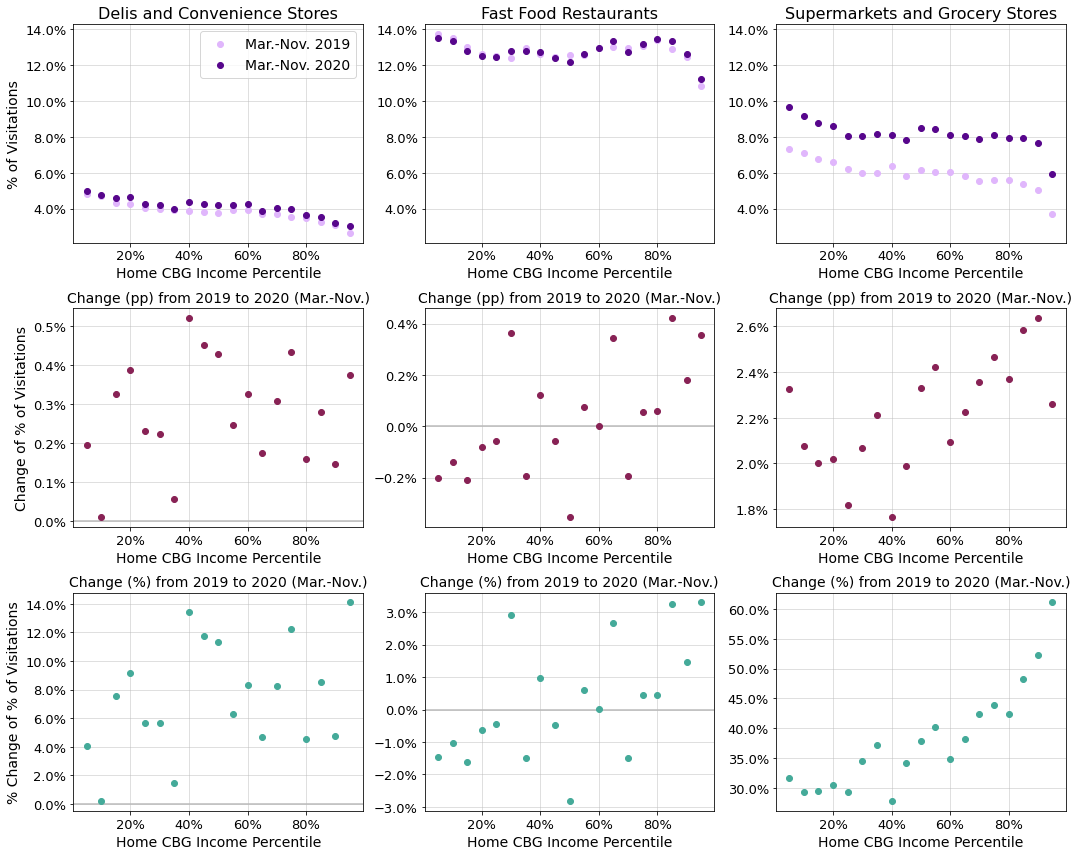

In [31]:
columns = [
    pdf_2020.columns[2],
    pdf_2020.columns[4],
    pdf_2020.columns[12],
]
plot_scatter(pdf_2019, pdf_2020, columns)

## By Cluster

In [34]:
cbg_km_df = cbg_df.drop(columns=['cluster']).rename(
    columns={'kmeans_cluster': 'cluster'})
km_cluster_df = home_weekly_df.merge(cbg_km_df, on=['cbg'], how='inner')

km_total_df = get_total_df(km_cluster_df)
km_weekly_df = get_weekly_df(km_cluster_df, km_total_df, poi_df=poi_other_df)
km_percent_df = get_percent_df(km_weekly_df)

km_percent_2019_df = km_percent_df.reset_index()
km_percent_2019_df = km_percent_2019_df[
    km_percent_2019_df['date_range_start'] >= DATE_START_PRE_COVID]
km_percent_2019_df = km_percent_2019_df[
    km_percent_2019_df['date_range_start'] <= DATE_END_PRE_COVID]
km_percent_2019_df = km_percent_2019_df.set_index(['date_range_start'])
km_percent_2019_mean_df = km_percent_2019_df.groupby(by=['cluster']).mean()
km_percent_2020_df = km_percent_df.reset_index()
km_percent_2020_df = km_percent_2020_df[
    km_percent_2020_df['date_range_start'] >= DATE_START_COVID]
km_percent_2020_df = km_percent_2020_df[
    km_percent_2020_df['date_range_start'] >= DATE_END_COVID]
km_percent_2020_df = km_percent_2020_df.set_index(['date_range_start'])
km_percent_2020_mean_df = km_percent_2020_df.groupby(by=['cluster']).mean()

kmdf_2020 = km_percent_2020_mean_df
kmdf_2019 = km_percent_2019_mean_df

,date_range_start,cluster,total_estimated_visitor_count
0,2018-12-31 00:00:00-05:00,0,462876.287917
1,2018-12-31 00:00:00-05:00,1,737236.363761
2,2018-12-31 00:00:00-05:00,2,654443.159494


432


,date_range_start,category,cluster,estimated_visitor_count,total_estimated_visitor_count,percent
0,2018-12-31 00:00:00-05:00,Fast Food Restaurants,0,66028.808146,462876.287917,0.142649
7,2018-12-31 00:00:00-05:00,Fast Food Restaurants,1,77418.567176,737236.363761,0.105012
14,2018-12-31 00:00:00-05:00,Fast Food Restaurants,2,81800.553611,654443.159494,0.124993


3024


category                           Fast Food Restaurants  \
date_range_start          cluster                          
2018-12-31 00:00:00-05:00 0                          NaN   
                          1                          NaN   
                          2                          NaN   

category                           Full-Service Restaurants  \
date_range_start          cluster                             
2018-12-31 00:00:00-05:00 0                             NaN   
                          1                             NaN   
                          2                             NaN   

category                           Limited-Service Restaurants  \
date_range_start          cluster                                
2018-12-31 00:00:00-05:00 0                                NaN   
                          1                                NaN   
                          2                                NaN   

category                           Other Food Retail  Other Food Service  \
date_range_start          cluster                                          
2018-12-31 00:00:00-05:00 0                      NaN                 NaN   
                          1                      NaN                 NaN   
                          2                      NaN                 NaN   

category                           Pharmacies and Drug Stores  \
date_range_start          cluster                               
2018-12-31 00:00:00-05:00 0                               NaN   
                          1                               NaN   
                          2                               NaN   

category                           Supermarkets and Grocery Stores  
date_range_start          cluster                                   
2018-12-31 00:00:00-05:00 0                                    NaN  
                          1                                    NaN  
                          2                                    NaN

440


In [35]:
def plot_bar(df1, df2, columns, yaxis_zero=True, last_col=-1):
    fig, ax = plt.subplots(3, len(columns), figsize=(5 * len(columns), 4 * 3))
    # Ignore top 1 percentiles due to 250+ reporting / outliers.
    for i, column in enumerate(columns):
        ax[0, i].bar(df1.index[0:last_col] - 0.125,
                     df1.iloc[0:last_col][column],
                     color=COLORS[1],
                     label='Mar.-Nov. 2019',
                     zorder=2,
                     width=0.25)
        ax[0, i].bar(df2.index[0:last_col] + 0.125,
                     df2.iloc[0:last_col][column],
                     color=COLORS[0],
                     label='Mar.-Nov. 2020',
                     zorder=3,
                     width=0.25)
        ax[0, i].set_title(column, fontsize=FONT_SIZE_TITLE)
        ax[0,
           i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
        ax[0, i].set_xlabel('Cluster', fontsize=FONT_SIZE_AXIS)
        ax[0, i].tick_params(axis='x', labelsize=FONT_SIZE_TICKS)
        ax[0, i].tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
        ax[0, i].sharey(ax[0, 0])
        ax[0, i].grid(color='#bdbdbd', alpha=0.6, zorder=1)
        ax[0, i].set_axisbelow(True)
    ax[0, 0].legend(fontsize=FONT_SIZE_LEGEND)

    for i, column in enumerate(columns):
        ax[1,
           i].bar(df1.index[0:last_col],
                  (df2.iloc[0:last_col][column] - df1.iloc[0:last_col][column]),
                  color=COLORS[2],
                  zorder=2)
        ax[1, i].set_title('Change (pp) from 2019 to 2020 (Mar.-Nov.)',
                           fontsize=FONT_SIZE_TITLE - 2)
        ax[1,
           i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
        ax[1, i].set_xlabel('Cluster', fontsize=FONT_SIZE_AXIS)
        ax[1, i].tick_params(axis='x', labelsize=FONT_SIZE_TICKS)
        ax[1, i].tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
        ax[1, i].grid(color='#bdbdbd', alpha=0.6, zorder=1)
        ax[1, i].set_axisbelow(True)
        # Draw horizontal line at zero
        if ax[1, i].get_ylim()[0] < 0 and ax[1, i].get_ylim()[1] > 0:
            ax[1, i].axhline(0, linestyle='-', color='#bbb', zorder=1)

    for i, column in enumerate(columns):
        ax[2, i].bar(
            df1.index[0:last_col],
            (df2.iloc[0:last_col][column] - df1.iloc[0:last_col][column]) /
            df1.iloc[0:last_col][column],
            color=COLORS[5],
            zorder=2)
        ax[2, i].set_title('Change (%) from 2019 to 2020 (Mar.-Nov.)',
                           fontsize=FONT_SIZE_TITLE - 2)
        ax[2,
           i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
        ax[2, i].set_xlabel('Cluster', fontsize=FONT_SIZE_AXIS)
        ax[2, i].tick_params(axis='x', labelsize=FONT_SIZE_TICKS)
        ax[2, i].tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
        ax[2, i].grid(color='#bdbdbd', alpha=0.6, zorder=1)
        ax[2, i].set_axisbelow(True)
        # Draw horizontal line at zero
        if ax[2, i].get_ylim()[0] < 0 and ax[1, i].get_ylim()[1] > 0:
            ax[2, i].axhline(0, linestyle='-', color='#bbb', zorder=1)

    ax[0, 0].set_ylabel('% of Visitations', fontsize=FONT_SIZE_AXIS)
    ax[1, 0].set_ylabel('Change of % of Visitations', fontsize=FONT_SIZE_AXIS)
    ax[2, 0].set_ylabel('% Change of % of Visitations', fontsize=FONT_SIZE_AXIS)

    #plt.suptitle('5% percentiles (Income)', fontsize=18)
    plt.tight_layout()
    plt.plot()

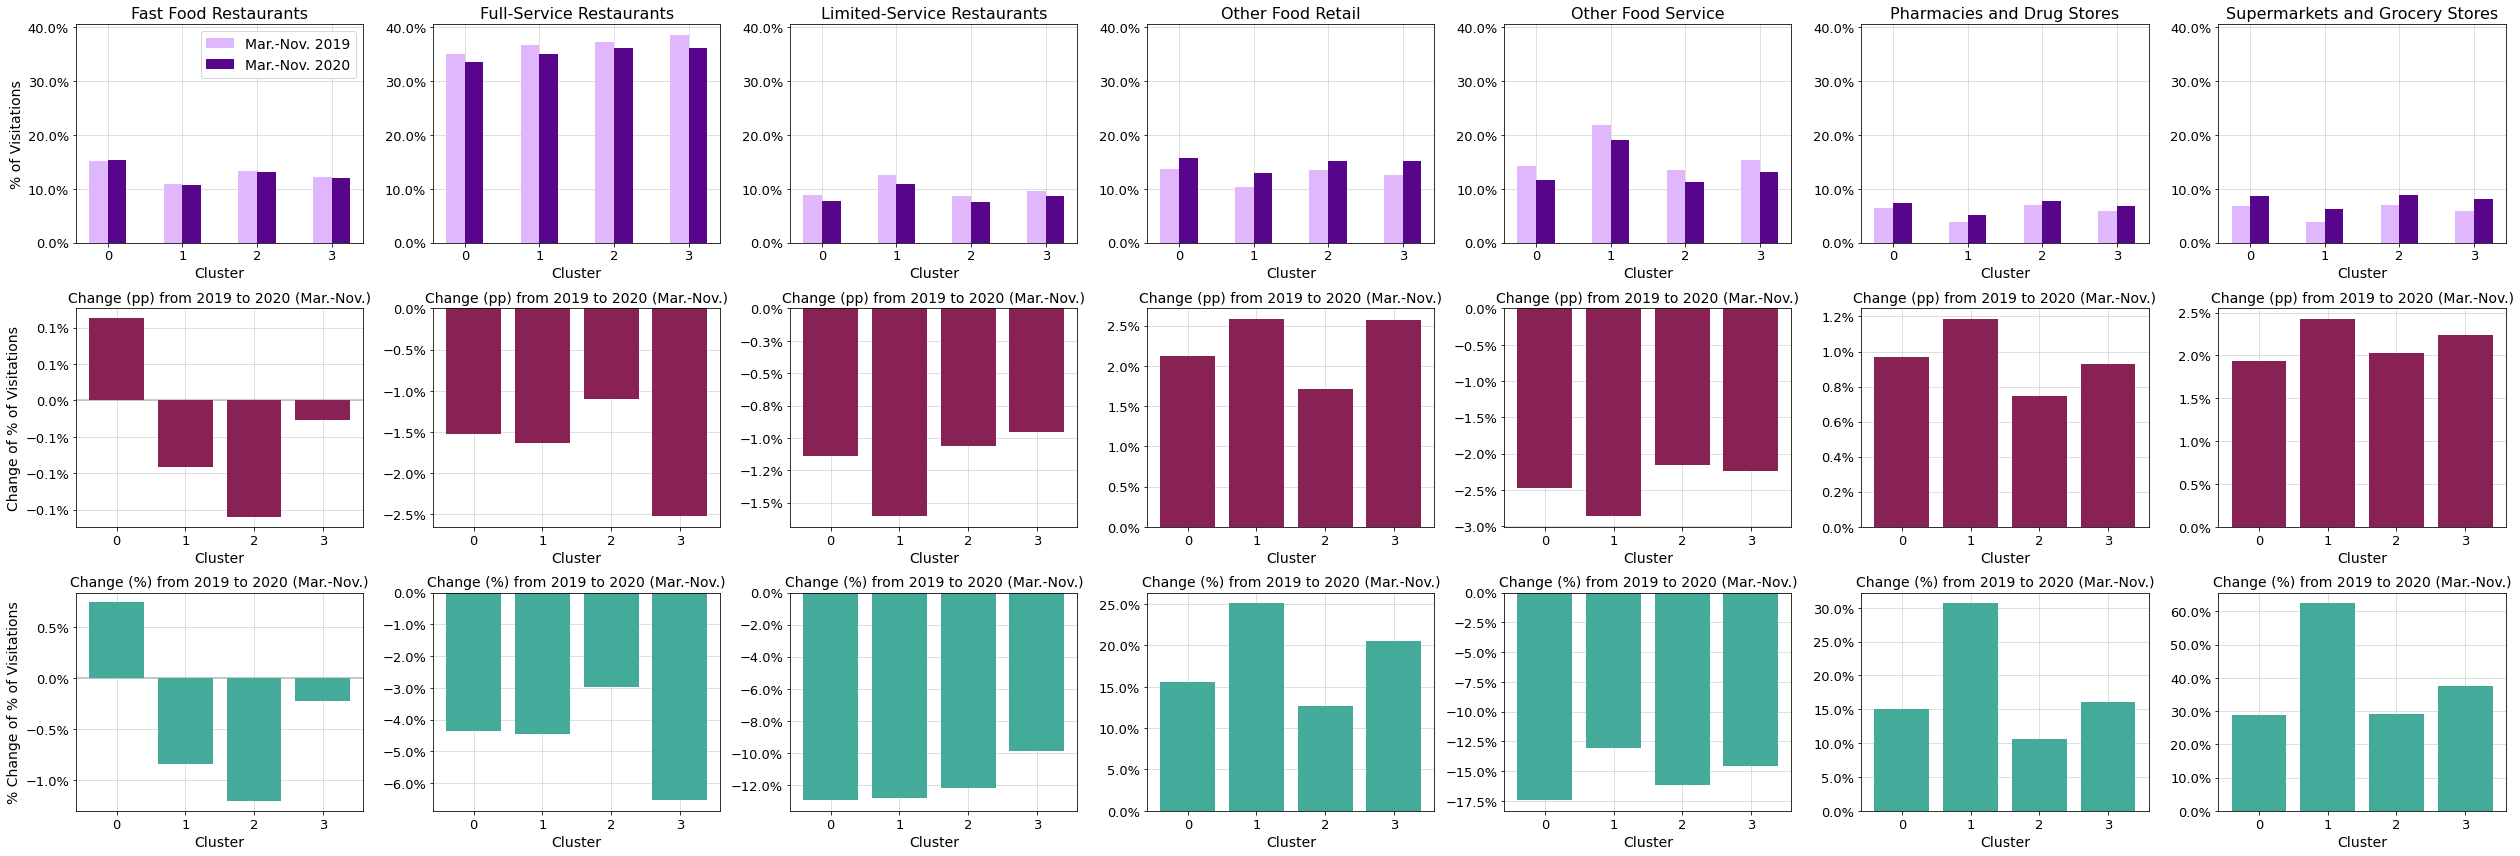

In [36]:
plot_bar(kmdf_2019, kmdf_2020, kmdf_2020.columns, last_col=None)

### Group into health-based categories

In [37]:
poi_hc_df = poi_df.copy()

unhealthy_food = [
    'Delis and Convenience Stores',
    'Fast Food Restaurants',
]

unhealthy_substances = [
    'Beer, Wine, and Liquor Stores',
    'Drinking Places',
    'Tobacco Stores',
]

healthy_food = [
    'Supermarkets and Grocery Stores',
]

other = [
    'Big Box Grocers',
    'Food Services',
    'Full-Service Restaurants',
    'General Merchandise Stores',
    'Limited-Service Restaurants',
    'Pharmacies and Drug Stores',
    'Snacks and Bakeries',
    'Specialty Food Stores',
]

poi_hc_df.loc[poi_hc_df['category'].isin(unhealthy_food), 'category'] = 'Less Healthy Food'
poi_hc_df.loc[poi_hc_df['category'].isin(unhealthy_substances), 'category'] = 'Less Healthy Substances'
poi_hc_df.loc[poi_hc_df['category'].isin(healthy_food), 'category'] = 'More Healthy Food'
poi_hc_df.loc[poi_hc_df['category'].isin(other), 'category'] = 'Other'

In [38]:
cbg_hc_df = apply_percentiles_by_income(cbg_df)
cbg_hc_df = cbg_hc_df[['cbg', 'cluster']]
hc_cluster_df = home_weekly_df.merge(cbg_hc_df, on=['cbg'], how='inner')
hc_total_df = get_total_df(hc_cluster_df)
hc_weekly_df = get_weekly_df(hc_cluster_df, hc_total_df, poi_df=poi_hc_df)
hc_percent_df = get_percent_df(hc_weekly_df)

,date_range_start,cluster,total_estimated_visitor_count
0,2018-12-31 00:00:00-05:00,5,130362.730020
1,2018-12-31 00:00:00-05:00,10,131410.450158
2,2018-12-31 00:00:00-05:00,15,132556.225098


2160


,date_range_start,category,cluster,estimated_visitor_count,total_estimated_visitor_count,percent
0,2018-12-31 00:00:00-05:00,Less Healthy Food,5,23328.685083,130362.730020,0.178952
4,2018-12-31 00:00:00-05:00,Less Healthy Food,10,23469.853487,131410.450158,0.178600
8,2018-12-31 00:00:00-05:00,Less Healthy Food,15,22752.734309,132556.225098,0.171646


8640


category                           Less Healthy Food  Less Healthy Substances  \
date_range_start          cluster                                               
2018-12-31 00:00:00-05:00 5                      NaN                      NaN   
                          10                     NaN                      NaN   
                          15                     NaN                      NaN   

category                           More Healthy Food  Other  
date_range_start          cluster                            
2018-12-31 00:00:00-05:00 5                      NaN    NaN  
                          10                     NaN    NaN  
                          15                     NaN    NaN

2200


In [39]:
hc_percent_2019_df = hc_percent_df.reset_index()
hc_percent_2019_df = hc_percent_2019_df[
    hc_percent_2019_df['date_range_start'] >= DATE_START_PRE_COVID]
hc_percent_2019_df = hc_percent_2019_df[
    hc_percent_2019_df['date_range_start'] <= DATE_END_PRE_COVID]
hc_percent_2019_df = hc_percent_2019_df.set_index(['date_range_start'])
hc_percent_2019_mean_df = hc_percent_2019_df.groupby(by=['cluster']).mean()
hc_percent_2020_df = hc_percent_df.reset_index()
hc_percent_2020_df = hc_percent_2020_df[
    hc_percent_2020_df['date_range_start'] >= DATE_START_COVID]
hc_percent_2020_df = hc_percent_2020_df[
    hc_percent_2020_df['date_range_start'] >= DATE_END_COVID]
hc_percent_2020_df = hc_percent_2020_df.set_index(['date_range_start'])
hc_percent_2020_mean_df = hc_percent_2020_df.groupby(by=['cluster']).mean()

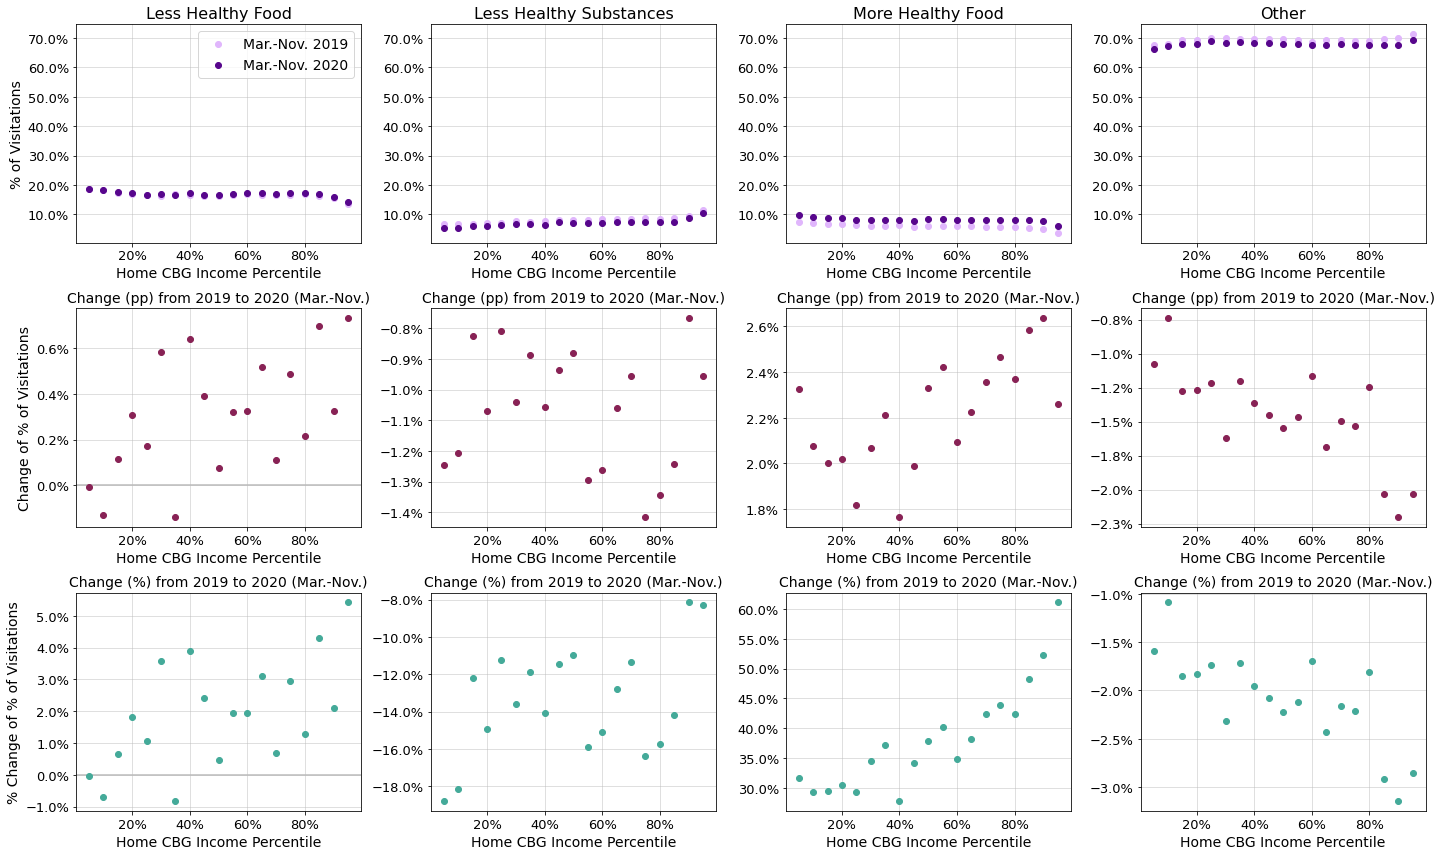

In [40]:
hc_df_2020 = hc_percent_2020_mean_df
hc_df_2019 = hc_percent_2019_mean_df
plot_scatter(hc_df_2019, hc_df_2020, hc_df_2020.columns)

### Group into food retail vs. service locations

In [41]:
cbg_rs_df = apply_percentiles_by_income(cbg_df)
cbg_rs_df = cbg_rs_df[['cbg', 'cluster']]
rs_cluster_df = home_weekly_df.merge(cbg_rs_df, on=['cbg'], how='inner')
rs_total_df = get_total_df(rs_cluster_df)
rs_weekly_df = get_weekly_df(rs_cluster_df, rs_total_df, poi_df=poi_rs_df)
rs_percent_df = get_percent_df(rs_weekly_df)

rs_percent_2019_df = rs_percent_df.reset_index()
rs_percent_2019_df = rs_percent_2019_df[
    rs_percent_2019_df['date_range_start'] >= DATE_START_PRE_COVID]
rs_percent_2019_df = rs_percent_2019_df[
    rs_percent_2019_df['date_range_start'] <= DATE_END_PRE_COVID]
rs_percent_2019_df = rs_percent_2019_df.set_index(['date_range_start'])
rs_percent_2019_mean_df = rs_percent_2019_df.groupby(by=['cluster']).mean()
rs_percent_2020_df = rs_percent_df.reset_index()
rs_percent_2020_df = rs_percent_2020_df[
    rs_percent_2020_df['date_range_start'] >= DATE_START_COVID]
rs_percent_2020_df = rs_percent_2020_df[
    rs_percent_2020_df['date_range_start'] >= DATE_END_COVID]
rs_percent_2020_df = rs_percent_2020_df.set_index(['date_range_start'])
rs_percent_2020_mean_df = rs_percent_2020_df.groupby(by=['cluster']).mean()

rs_df_2020 = rs_percent_2020_mean_df
rs_df_2019 = rs_percent_2019_mean_df

,date_range_start,cluster,total_estimated_visitor_count
0,2018-12-31 00:00:00-05:00,5,130362.730020
1,2018-12-31 00:00:00-05:00,10,131410.450158
2,2018-12-31 00:00:00-05:00,15,132556.225098


2160


,date_range_start,category,cluster,estimated_visitor_count,total_estimated_visitor_count,percent
0,2018-12-31 00:00:00-05:00,Food Retail,5,38923.243792,130362.730020,0.298576
2,2018-12-31 00:00:00-05:00,Food Retail,10,38132.746094,131410.450158,0.290180
4,2018-12-31 00:00:00-05:00,Food Retail,15,37000.800676,132556.225098,0.279133


4320


category                           Food Retail  Food Service
date_range_start          cluster                           
2018-12-31 00:00:00-05:00 5                NaN           NaN
                          10               NaN           NaN
                          15               NaN           NaN

2200


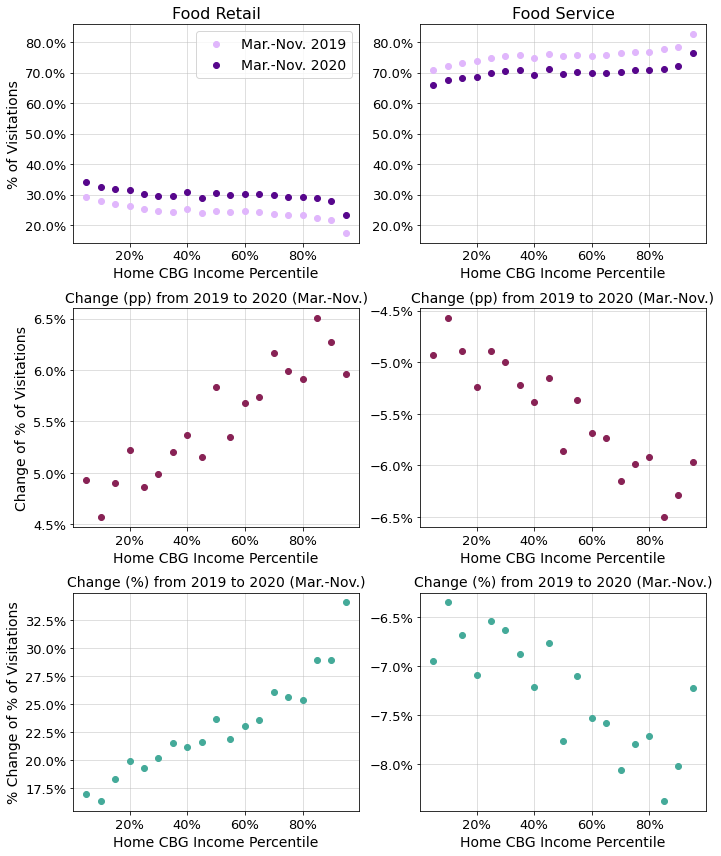

In [42]:
plot_scatter(rs_df_2019, rs_df_2020, rs_df_2020.columns)